# Assignment Week 2 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins


From the dataset your group has selected, complete the following tasks and prepare a paper
(at least 6 pages, double-spaced, Times New Roman font size 12, include a cover page) and articulate your findings.

1. Generate a linear and a logistic regression model to predict an outcome. The outcomes can be different from each other.

2. Explain the results of the models using performance metrics such as Coefficient of Determination, QQ plots, Residual Plots, Confusion matrix etc.

3. Improve the model using regularization and address multicollinearity in the data

4. Explain your modeling conclusions. 

Note: Try to engineer features to extract non-linear relationships in the data.

# Data Preparation

## Data Selection

### Import libraries

In [274]:
# main libraries
import pandas as pd
import numpy as np

# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Read data

In [275]:
fraudTrain = pd.read_csv("../fraudTrain.csv")
fraudTest = pd.read_csv("../fraudTest.csv")

In [276]:
# Joining fraudTrain and fraudTest datasets
fraud_df = fraudTrain.append(fraudTest)
# fraud_df.head()

## Data Preprocessing

### Data formatting and cleansing

In [277]:
fraud_df = fraud_df.drop(columns=['Unnamed: 0'])

In [278]:
# Converting dob to age 
## To parse all datetime columns in advance
fraud_df['dob'] = pd.to_datetime(fraud_df['dob'], errors='coerce')

now = pd.to_datetime('now')

## Create a new column age
fraud_df['dob']=(now.year - fraud_df['dob'].dt.year) - ((now.month - fraud_df['dob'].dt.month) < 0)

fraud_df = fraud_df.rename(columns={'dob': 'age'})

In [279]:
# Converting unix timestamp to datetime
fraud_df['unix_time'] = pd.to_datetime(fraud_df['unix_time'], unit='s')

In [280]:
# female = 0, male = 1 
labelencoder = LabelEncoder()
label = labelencoder.fit_transform(fraud_df['gender'])
fraud_df['gender']=label

In [281]:
fraud_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,age,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,0,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",32,0b242abb623afc578575680df30655b9,2012-01-01 00:00:18,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,42,1f76529f8574734946361c461b024d99,2012-01-01 00:00:44,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,1,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,58,a1a22d70485983eac12b5b88dad1cf95,2012-01-01 00:00:51,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,53,6b849c168bdad6f867558c3793159a81,2012-01-01 00:01:16,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,1,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,34,a41d7549acf90789359a9aa5346dcb46,2012-01-01 00:03:06,38.674999,-78.632459,0


In [282]:
print(fraud_df.shape)

(1852394, 22)


### Checking for missing values

In [283]:
fraud_df.isnull().any().sum()

0

### Checking for data types

In [284]:
fraud_df.dtypes

trans_date_trans_time            object
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                            int64
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
age                               int64
trans_num                        object
unix_time                datetime64[ns]
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
dtype: object

### Checking for unique values

In [285]:
fraud_df.nunique()

trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
age                           82
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

#### Take a look at column 'is_fraud'

In the column 'is_fraud', data are Labeled as 0's and 1's. 

0 = non fraud, 1 = fraud

In [286]:
All = fraud_df.shape[0]
fraud = fraud_df[fraud_df['is_fraud'] == 1]
nonFraud = fraud_df[fraud_df['is_fraud'] == 0]

a = len(fraud)/All
b = len(nonFraud)/All

print('frauds :',a*100,'%')
print('non frauds :',b*100,'%')

frauds : 0.5210014716091717 %
non frauds : 99.47899852839083 %


## Data Transformation 

### Standardize the data

In [287]:
# fraud_df.columns
data = fraud_df[['amt', 'gender', 'zip','lat','long', 'city_pop','age','merch_lat','merch_long','is_fraud']]
features = fraud_df[['amt', 'gender', 'zip','lat','long', 'city_pop','age','merch_lat','merch_long']]
target = fraud_df[['is_fraud']]

In [288]:
scaler = StandardScaler()

scaler.fit(data)

features = scaler.transform(data)

### Principal Component Analysis

In [289]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

In [290]:
pca.fit(data)
data =pca.transform(data)

### Data splitting

In [291]:
x = fraud_df[['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt','first', 'last', 'gender','street','city',
              'state', 'zip', 'lat','long', 'city_pop', 'job', 'age', 'trans_num', 'unix_time', 'merch_lat','merch_long']]
y = fraud_df[['is_fraud']]

In [292]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=123)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1296675, 21)
(1296675, 1)
(555719, 21)
(555719, 1)


## Correlation Matrix

In [293]:
corrMatrix = fraud_df.corr()
print (corrMatrix)

              cc_num       amt    gender       zip       lat      long  \
cc_num      1.000000  0.001826  0.000333  0.041504 -0.058744 -0.048429   
amt         0.001826  1.000000  0.000740  0.001979 -0.000670 -0.000735   
gender      0.000333  0.000740  1.000000 -0.066106  0.042862  0.050653   
zip         0.041504  0.001979 -0.066106  1.000000 -0.114554 -0.909795   
lat        -0.058744 -0.000670  0.042862 -0.114554  1.000000 -0.014744   
long       -0.048429 -0.000735  0.050653 -0.909795 -0.014744  1.000000   
city_pop   -0.009118  0.004921 -0.028862  0.077601 -0.154816 -0.052359   
age        -0.000312 -0.010604  0.004718  0.009735  0.047874 -0.029061   
merch_lat  -0.058415 -0.000613  0.042621 -0.113934  0.993582 -0.014585   
merch_long -0.048421 -0.000711  0.050606 -0.908981 -0.014709  0.999118   
is_fraud   -0.001125  0.209308  0.005844 -0.002190  0.002904  0.001022   

            city_pop       age  merch_lat  merch_long  is_fraud  
cc_num     -0.009118 -0.000312  -0.058415   -

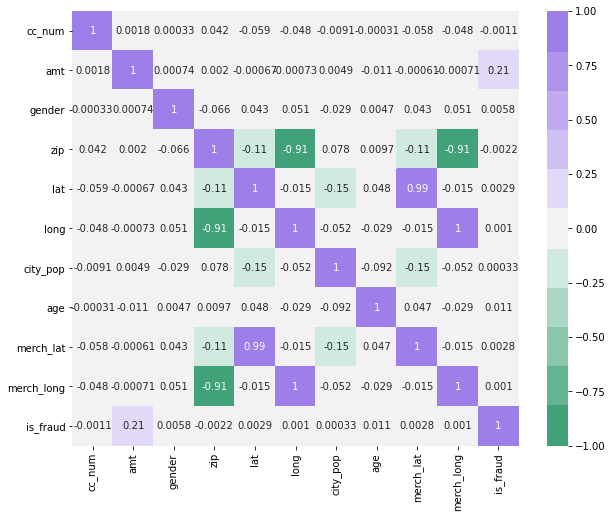

In [294]:
plt.figure(figsize=(10, 8))
#cmap = sns.diverging_palette(250, 30, l=65, as_cmap=True)
cmap =  sns.diverging_palette(150, 275, s=80, l=60, n=11)
sn.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center= 0, cmap=cmap)
plt.show()

In [ ]:
# Linear Regression Model

In [ ]:
# Logistic Regression Model

# References
[1] https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

[2] https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

[3] https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

[4] https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 

[5] https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234